<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Boosting </center></h2>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Load Dataset

Load data from `data/x_data.tsv` and `data/y_data.tsv`. 

These are descriptive features and target feature. Put them in `X` and `y` respectively.

In [2]:
df_X = pd.read_csv('./data/x_train.csv', sep=';')
df_y = pd.read_csv('./data/y_train.csv', sep=';', header=None,
                  names=['target'])

In [3]:
df_X.head()
df_y.head()

,target
0,0
1,1
2,1
3,1
4,0


In [8]:
df_X.head()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
0,39,10,3,17,24.444444,1,5,0.400000,2650000,1375,21,2
1,21,22,19,55,17.045455,1,6,0.333333,5614000,3825,51,4
2,5,6,1,6,8.400000,0,1,1.000000,857000,1150,14,1
3,21,2,5,6,19.000000,0,1,0.000000,120000,0,1,1
4,4,5,1,5,9.600000,0,1,1.000000,857000,1075,12,1


In [4]:
df_X.shape

(25289, 12)

In [5]:
df_y.shape

(25289, 1)

In [6]:
X = df_X.values
y = df_y.values

# Adaboost

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123, test_size=0.2)

In [20]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                         n_estimators=1000, 
                         learning_rate=1., 
                         random_state=123)

In [21]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=1000, random_state=123)

In [22]:
scores_train = []
scores_valid = []

for y_pred in ada.staged_predict_proba(X_train):
    scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
    
for y_pred in ada.staged_predict_proba(X_valid):
    scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1]))

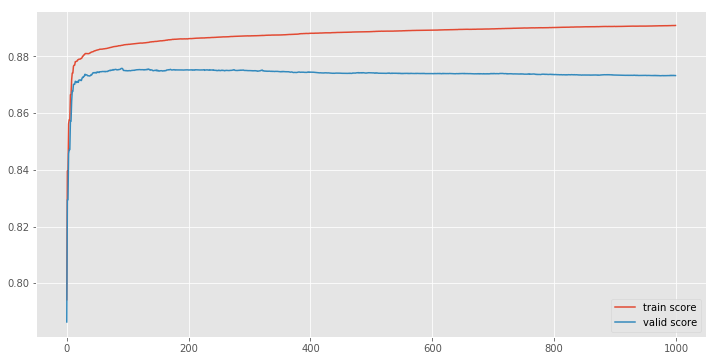

In [23]:
plt.plot(scores_train, label='train score')
plt.plot(scores_valid, label='valid score')
plt.legend()

In [24]:
cv = StratifiedKFold(n_splits=4, random_state=123)
scoring = 'roc_auc'

scores = cross_val_score(ada, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.87601413287188357

# Gradient boosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

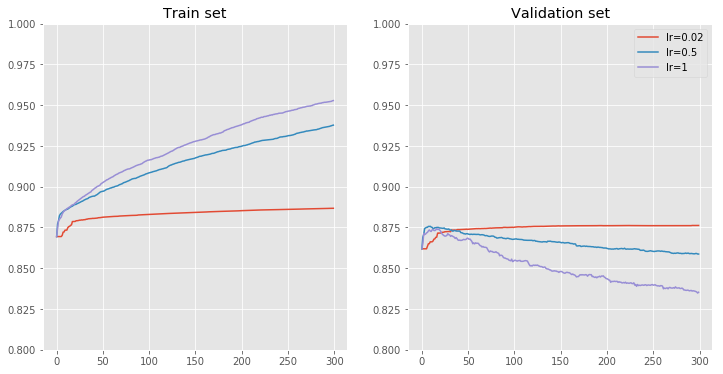

In [30]:
fig, ax = plt.subplots(1,2)

for lr in [0.02, 0.5, 1]:

    model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=lr,
                                       random_state=123)
    model.fit(X_train, y_train)

    scores_train = []
    scores_valid = []

    for y_pred in model.staged_predict_proba(X_train):
        scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
        
    ax[0].plot(scores_train, label='lr={}'.format(lr))
    ax[0].set_title('Train set')

    for y_pred in model.staged_predict_proba(X_valid):
        scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1])) 
        
    ax[1].plot(scores_valid, label='lr={}'.format(lr))
    ax[1].set_title('Validation set')
    
    
ax[0].set_ylim((0.8, 1))
ax[1].set_ylim((0.8, 1))
plt.legend()


In [31]:
model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=0.02, 
                                       random_state=123)

In [32]:
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.87990756049955854

In [33]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [34]:
imp = pd.Series(index=df_X.columns, data=model.feature_importances_)

In [36]:
imp.sort_values()

doReturnOnLowerLevels                 0.003267
numberOfAttemptedLevels               0.003750
totalStarsCount                       0.011624
totalBonusScore                       0.021913
fractionOfUsefullBoosters             0.028718
attemptsOnTheHighestLevel             0.048529
totalScore                            0.066346
numberOfBoostersUsed                  0.066444
maxPlayerLevel                        0.109797
averageNumOfTurnsPerCompletedLevel    0.110087
totalNumOfAttempts                    0.253958
numberOfDaysActuallyPlayed            0.275568
dtype: float64

# Partial dependency plot

In [37]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

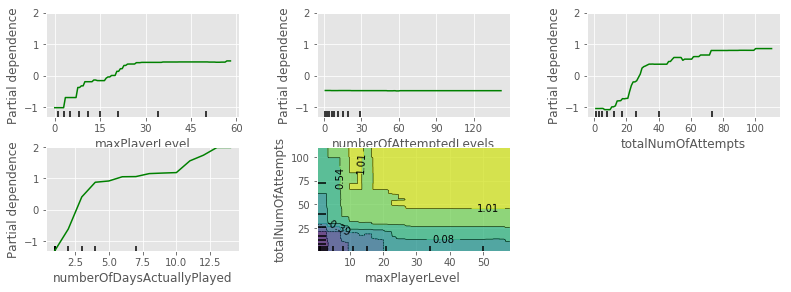

In [43]:
fig, ax =\
plot_partial_dependence(model, X_train, [0, 1, 3, 11, (0,3)], 
                        feature_names=df_X.columns)

In [44]:
pdp, axes = partial_dependence(model, [0], X=X_train, )

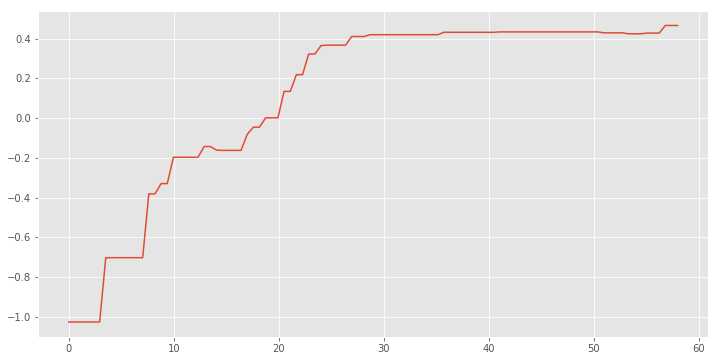

In [45]:
plt.plot(axes[0], pdp[0])

# Other libraries... maybe...

In [47]:
import catboost as cb

In [58]:
model = cb.CatBoostClassifier(eval_metric='AUC', iterations=1000, 
                              verbose='Info',
                              depth=5,
                              learning_rate=0.02, )

In [70]:
model.fit(X_train, y=y_train, eval_set=(X_valid, y_valid), 
          use_best_model=True)

0:	learn: 0.8529407	test: 0.8459639	best: 0.8459639 (0)	total: 135ms	remaining: 2m 15s
1:	learn: 0.8656523	test: 0.8588549	best: 0.8588549 (1)	total: 202ms	remaining: 1m 40s
2:	learn: 0.8687305	test: 0.8621517	best: 0.8621517 (2)	total: 284ms	remaining: 1m 34s
3:	learn: 0.8706560	test: 0.8636893	best: 0.8636893 (3)	total: 373ms	remaining: 1m 32s
4:	learn: 0.8709490	test: 0.8635745	best: 0.8636893 (3)	total: 437ms	remaining: 1m 26s
5:	learn: 0.8726854	test: 0.8654620	best: 0.8654620 (5)	total: 502ms	remaining: 1m 23s
6:	learn: 0.8739910	test: 0.8669448	best: 0.8669448 (6)	total: 566ms	remaining: 1m 20s
7:	learn: 0.8760809	test: 0.8696537	best: 0.8696537 (7)	total: 646ms	remaining: 1m 20s
8:	learn: 0.8764852	test: 0.8701085	best: 0.8701085 (8)	total: 698ms	remaining: 1m 16s
9:	learn: 0.8772505	test: 0.8712993	best: 0.8712993 (9)	total: 754ms	remaining: 1m 14s
10:	learn: 0.8775275	test: 0.8716939	best: 0.8716939 (10)	total: 816ms	remaining: 1m 13s
11:	learn: 0.8775062	test: 0.8714397	best

95:	learn: 0.8807163	test: 0.8744805	best: 0.8745203 (93)	total: 6.41s	remaining: 1m
96:	learn: 0.8807229	test: 0.8744972	best: 0.8745203 (93)	total: 6.47s	remaining: 1m
97:	learn: 0.8807168	test: 0.8745013	best: 0.8745203 (93)	total: 6.53s	remaining: 1m
98:	learn: 0.8807292	test: 0.8745073	best: 0.8745203 (93)	total: 6.59s	remaining: 59.9s
99:	learn: 0.8807549	test: 0.8744840	best: 0.8745203 (93)	total: 6.65s	remaining: 59.9s
100:	learn: 0.8807777	test: 0.8745242	best: 0.8745242 (100)	total: 6.71s	remaining: 59.7s
101:	learn: 0.8808168	test: 0.8745534	best: 0.8745534 (101)	total: 6.77s	remaining: 59.6s
102:	learn: 0.8808565	test: 0.8745909	best: 0.8745909 (102)	total: 6.85s	remaining: 59.6s
103:	learn: 0.8809012	test: 0.8746281	best: 0.8746281 (103)	total: 6.94s	remaining: 59.8s
104:	learn: 0.8809085	test: 0.8746127	best: 0.8746281 (103)	total: 7.04s	remaining: 60s
105:	learn: 0.8809378	test: 0.8746494	best: 0.8746494 (105)	total: 7.11s	remaining: 60s
106:	learn: 0.8809483	test: 0.874

187:	learn: 0.8825869	test: 0.8751607	best: 0.8751607 (187)	total: 12.2s	remaining: 52.7s
188:	learn: 0.8825970	test: 0.8751789	best: 0.8751789 (188)	total: 12.3s	remaining: 52.6s
189:	learn: 0.8826221	test: 0.8751619	best: 0.8751789 (188)	total: 12.3s	remaining: 52.5s
190:	learn: 0.8826242	test: 0.8751702	best: 0.8751789 (188)	total: 12.4s	remaining: 52.4s
191:	learn: 0.8826538	test: 0.8751841	best: 0.8751841 (191)	total: 12.4s	remaining: 52.3s
192:	learn: 0.8826678	test: 0.8751731	best: 0.8751841 (191)	total: 12.5s	remaining: 52.2s
193:	learn: 0.8826912	test: 0.8752042	best: 0.8752042 (193)	total: 12.5s	remaining: 52.1s
194:	learn: 0.8827233	test: 0.8752371	best: 0.8752371 (194)	total: 12.6s	remaining: 52.1s
195:	learn: 0.8827385	test: 0.8752516	best: 0.8752516 (195)	total: 12.7s	remaining: 52s
196:	learn: 0.8827581	test: 0.8752522	best: 0.8752522 (196)	total: 12.8s	remaining: 52.1s
197:	learn: 0.8827920	test: 0.8752852	best: 0.8752852 (197)	total: 12.8s	remaining: 52s
198:	learn: 0.

281:	learn: 0.8841380	test: 0.8758317	best: 0.8758317 (281)	total: 18s	remaining: 45.9s
282:	learn: 0.8841581	test: 0.8758398	best: 0.8758398 (282)	total: 18.1s	remaining: 45.8s
283:	learn: 0.8841708	test: 0.8758466	best: 0.8758466 (283)	total: 18.1s	remaining: 45.7s
284:	learn: 0.8841967	test: 0.8758630	best: 0.8758630 (284)	total: 18.2s	remaining: 45.7s
285:	learn: 0.8842153	test: 0.8758614	best: 0.8758630 (284)	total: 18.3s	remaining: 45.6s
286:	learn: 0.8842346	test: 0.8758750	best: 0.8758750 (286)	total: 18.3s	remaining: 45.5s
287:	learn: 0.8842452	test: 0.8758827	best: 0.8758827 (287)	total: 18.4s	remaining: 45.4s
288:	learn: 0.8842703	test: 0.8758887	best: 0.8758887 (288)	total: 18.4s	remaining: 45.3s
289:	learn: 0.8842852	test: 0.8759011	best: 0.8759011 (289)	total: 18.5s	remaining: 45.2s
290:	learn: 0.8843015	test: 0.8758988	best: 0.8759011 (289)	total: 18.6s	remaining: 45.2s
291:	learn: 0.8843148	test: 0.8759040	best: 0.8759040 (291)	total: 18.6s	remaining: 45.2s
292:	learn: 

374:	learn: 0.8854333	test: 0.8761542	best: 0.8761542 (374)	total: 23.8s	remaining: 39.7s
375:	learn: 0.8854490	test: 0.8761613	best: 0.8761613 (375)	total: 23.9s	remaining: 39.6s
376:	learn: 0.8854948	test: 0.8761097	best: 0.8761613 (375)	total: 23.9s	remaining: 39.6s
377:	learn: 0.8855128	test: 0.8761149	best: 0.8761613 (375)	total: 24s	remaining: 39.5s
378:	learn: 0.8855257	test: 0.8761228	best: 0.8761613 (375)	total: 24.1s	remaining: 39.5s
379:	learn: 0.8855255	test: 0.8761163	best: 0.8761613 (375)	total: 24.2s	remaining: 39.4s
380:	learn: 0.8855349	test: 0.8761284	best: 0.8761613 (375)	total: 24.2s	remaining: 39.4s
381:	learn: 0.8855444	test: 0.8761312	best: 0.8761613 (375)	total: 24.3s	remaining: 39.3s
382:	learn: 0.8855583	test: 0.8761317	best: 0.8761613 (375)	total: 24.4s	remaining: 39.3s
383:	learn: 0.8855674	test: 0.8761346	best: 0.8761613 (375)	total: 24.5s	remaining: 39.3s
384:	learn: 0.8855747	test: 0.8761399	best: 0.8761613 (375)	total: 24.5s	remaining: 39.2s
385:	learn: 

466:	learn: 0.8865447	test: 0.8763337	best: 0.8763337 (466)	total: 30.2s	remaining: 34.4s
467:	learn: 0.8865531	test: 0.8763405	best: 0.8763405 (467)	total: 30.2s	remaining: 34.4s
468:	learn: 0.8865610	test: 0.8763440	best: 0.8763440 (468)	total: 30.3s	remaining: 34.3s
469:	learn: 0.8865605	test: 0.8763440	best: 0.8763440 (469)	total: 30.4s	remaining: 34.3s
470:	learn: 0.8865642	test: 0.8763421	best: 0.8763440 (469)	total: 30.5s	remaining: 34.2s
471:	learn: 0.8865704	test: 0.8763446	best: 0.8763446 (471)	total: 30.6s	remaining: 34.2s
472:	learn: 0.8865784	test: 0.8763492	best: 0.8763492 (472)	total: 30.6s	remaining: 34.1s
473:	learn: 0.8865975	test: 0.8763622	best: 0.8763622 (473)	total: 30.7s	remaining: 34.1s
474:	learn: 0.8866093	test: 0.8763662	best: 0.8763662 (474)	total: 30.8s	remaining: 34s
475:	learn: 0.8866215	test: 0.8763657	best: 0.8763662 (474)	total: 30.9s	remaining: 34s
476:	learn: 0.8866275	test: 0.8763580	best: 0.8763662 (474)	total: 31s	remaining: 34s
477:	learn: 0.8866

561:	learn: 0.8876348	test: 0.8766314	best: 0.8766314 (561)	total: 36.6s	remaining: 28.5s
562:	learn: 0.8876419	test: 0.8766235	best: 0.8766314 (561)	total: 36.7s	remaining: 28.5s
563:	learn: 0.8876606	test: 0.8766355	best: 0.8766355 (563)	total: 36.7s	remaining: 28.4s
564:	learn: 0.8876792	test: 0.8766283	best: 0.8766355 (563)	total: 36.8s	remaining: 28.3s
565:	learn: 0.8877026	test: 0.8766536	best: 0.8766536 (565)	total: 36.8s	remaining: 28.2s
566:	learn: 0.8877128	test: 0.8766548	best: 0.8766548 (566)	total: 36.9s	remaining: 28.2s
567:	learn: 0.8877245	test: 0.8766649	best: 0.8766649 (567)	total: 36.9s	remaining: 28.1s
568:	learn: 0.8877389	test: 0.8766552	best: 0.8766649 (567)	total: 37s	remaining: 28s
569:	learn: 0.8877719	test: 0.8766560	best: 0.8766649 (567)	total: 37.1s	remaining: 28s
570:	learn: 0.8877954	test: 0.8766504	best: 0.8766649 (567)	total: 37.1s	remaining: 27.9s
571:	learn: 0.8878067	test: 0.8766569	best: 0.8766649 (567)	total: 37.2s	remaining: 27.8s
572:	learn: 0.88

653:	learn: 0.8889703	test: 0.8768924	best: 0.8769123 (647)	total: 42.4s	remaining: 22.4s
654:	learn: 0.8889861	test: 0.8768926	best: 0.8769123 (647)	total: 42.4s	remaining: 22.3s
655:	learn: 0.8889957	test: 0.8768880	best: 0.8769123 (647)	total: 42.5s	remaining: 22.3s
656:	learn: 0.8890062	test: 0.8768785	best: 0.8769123 (647)	total: 42.5s	remaining: 22.2s
657:	learn: 0.8890217	test: 0.8768874	best: 0.8769123 (647)	total: 42.6s	remaining: 22.1s
658:	learn: 0.8890292	test: 0.8768835	best: 0.8769123 (647)	total: 42.6s	remaining: 22.1s
659:	learn: 0.8890426	test: 0.8768986	best: 0.8769123 (647)	total: 42.7s	remaining: 22s
660:	learn: 0.8890854	test: 0.8769651	best: 0.8769651 (660)	total: 42.8s	remaining: 21.9s
661:	learn: 0.8890976	test: 0.8769698	best: 0.8769698 (661)	total: 42.8s	remaining: 21.9s
662:	learn: 0.8891046	test: 0.8769634	best: 0.8769698 (661)	total: 42.9s	remaining: 21.8s
663:	learn: 0.8891122	test: 0.8769528	best: 0.8769698 (661)	total: 43s	remaining: 21.8s
664:	learn: 0.

746:	learn: 0.8901549	test: 0.8772470	best: 0.8772627 (741)	total: 47.9s	remaining: 16.2s
747:	learn: 0.8901618	test: 0.8772524	best: 0.8772627 (741)	total: 48s	remaining: 16.2s
748:	learn: 0.8901895	test: 0.8772509	best: 0.8772627 (741)	total: 48s	remaining: 16.1s
749:	learn: 0.8902087	test: 0.8772546	best: 0.8772627 (741)	total: 48.1s	remaining: 16s
750:	learn: 0.8902187	test: 0.8772437	best: 0.8772627 (741)	total: 48.2s	remaining: 16s
751:	learn: 0.8902360	test: 0.8772350	best: 0.8772627 (741)	total: 48.3s	remaining: 15.9s
752:	learn: 0.8902704	test: 0.8772569	best: 0.8772627 (741)	total: 48.3s	remaining: 15.8s
753:	learn: 0.8902801	test: 0.8772521	best: 0.8772627 (741)	total: 48.4s	remaining: 15.8s
754:	learn: 0.8902913	test: 0.8772521	best: 0.8772627 (741)	total: 48.5s	remaining: 15.7s
755:	learn: 0.8903078	test: 0.8772627	best: 0.8772627 (755)	total: 48.6s	remaining: 15.7s
756:	learn: 0.8903179	test: 0.8772646	best: 0.8772646 (756)	total: 48.6s	remaining: 15.6s
757:	learn: 0.8903

840:	learn: 0.8912210	test: 0.8773454	best: 0.8773766 (804)	total: 54.3s	remaining: 10.3s
841:	learn: 0.8912250	test: 0.8773444	best: 0.8773766 (804)	total: 54.4s	remaining: 10.2s
842:	learn: 0.8912335	test: 0.8773438	best: 0.8773766 (804)	total: 54.5s	remaining: 10.1s
843:	learn: 0.8912456	test: 0.8773429	best: 0.8773766 (804)	total: 54.5s	remaining: 10.1s
844:	learn: 0.8912527	test: 0.8773396	best: 0.8773766 (804)	total: 54.6s	remaining: 10s
845:	learn: 0.8912654	test: 0.8773490	best: 0.8773766 (804)	total: 54.7s	remaining: 9.95s
846:	learn: 0.8912732	test: 0.8773597	best: 0.8773766 (804)	total: 54.8s	remaining: 9.89s
847:	learn: 0.8912876	test: 0.8773481	best: 0.8773766 (804)	total: 54.8s	remaining: 9.83s
848:	learn: 0.8913027	test: 0.8773543	best: 0.8773766 (804)	total: 54.9s	remaining: 9.77s
849:	learn: 0.8913107	test: 0.8773552	best: 0.8773766 (804)	total: 55s	remaining: 9.71s
850:	learn: 0.8913184	test: 0.8773541	best: 0.8773766 (804)	total: 55.1s	remaining: 9.64s
851:	learn: 0.

935:	learn: 0.8921318	test: 0.8775539	best: 0.8775635 (934)	total: 1m	remaining: 4.14s
936:	learn: 0.8921615	test: 0.8775661	best: 0.8775661 (936)	total: 1m	remaining: 4.08s
937:	learn: 0.8921678	test: 0.8775649	best: 0.8775661 (936)	total: 1m	remaining: 4.01s
938:	learn: 0.8921747	test: 0.8775641	best: 0.8775661 (936)	total: 1m	remaining: 3.95s
939:	learn: 0.8921800	test: 0.8775649	best: 0.8775661 (936)	total: 1m	remaining: 3.88s
940:	learn: 0.8921889	test: 0.8775633	best: 0.8775661 (936)	total: 1m	remaining: 3.82s
941:	learn: 0.8922016	test: 0.8775715	best: 0.8775715 (941)	total: 1m	remaining: 3.75s
942:	learn: 0.8922108	test: 0.8775688	best: 0.8775715 (941)	total: 1m	remaining: 3.69s
943:	learn: 0.8922246	test: 0.8775707	best: 0.8775715 (941)	total: 1m 1s	remaining: 3.62s
944:	learn: 0.8922377	test: 0.8775649	best: 0.8775715 (941)	total: 1m 1s	remaining: 3.56s
945:	learn: 0.8922544	test: 0.8775688	best: 0.8775715 (941)	total: 1m 1s	remaining: 3.49s
946:	learn: 0.8922670	test: 0.8775

In [74]:
feat_imp = model.get_feature_importance(X_train, 
                                        y=y_train, 
                                        fstr_type='Doc')